# Load library

In [2]:
import os
import pandas as pd
import numpy as np
import datetime

import requests
from bs4 import BeautifulSoup
import time

#import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.stats.outliers_influence import variance_inflation_factor

# RCT

## Load balanced data

In [2]:
raw = pd.read_csv('./data/AB test/Numpy AB Testing.csv')
raw.head(3)

User ID Group  Page Views  Time Spent Conversion   Device          Location
0    14292     B           3         424         No   Mobile  Northern Ireland
1    11682     A           9         342         No   Mobile          Scotland
2    19825     A           2         396         No  Desktop  Northern Ireland

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB


## EDA

In [4]:
raw.describe()

User ID   Page Views   Time Spent
count   5000.000000  5000.000000  5000.000000
mean   14925.159000     7.537600   242.512600
std     2869.153773     4.022465   118.254153
min    10001.000000     1.000000    40.000000
25%    12456.250000     4.000000   137.000000
50%    14858.500000     8.000000   243.000000
75%    17379.750000    11.000000   346.000000
max    19995.000000    14.000000   449.000000

In [5]:
raw.groupby('Group').describe().T.round(1) # 표본평균 및 분산 확인

Group                   A        B
User ID    count   2519.0   2481.0
           mean   14973.9  14875.7
           std     2858.1   2880.1
           min    10001.0  10005.0
           25%    12540.5  12367.0
           50%    14902.0  14815.0
           75%    17451.0  17309.0
           max    19995.0  19993.0
Page Views count   2519.0   2481.0
           mean       7.6      7.5
           std        4.1      4.0
           min        1.0      1.0
           25%        4.0      4.0
           50%        8.0      8.0
           75%       11.0     11.0
           max       14.0     14.0
Time Spent count   2519.0   2481.0
           mean     241.7    243.3
           std      117.3    119.2
           min       40.0     40.0
           25%      137.5    136.0
           50%      241.0    244.0
           75%      343.0    348.0
           max      449.0    449.0

In [6]:
pd.DataFrame(raw.groupby('Group')['Conversion'].value_counts(normalize=True)).sort_index() # 균형 확인

proportion
Group Conversion            
A     No            0.946010
      Yes           0.053990
B     No            0.859331
      Yes           0.140669

In [7]:
pd.DataFrame(raw.groupby('Group')['Device'].value_counts(normalize=True)).sort_index()

proportion
Group Device             
A     Desktop    0.493847
      Mobile     0.506153
B     Desktop    0.521564
      Mobile     0.478436

In [8]:
pd.DataFrame(raw.groupby('Group')['Location'].value_counts(normalize=True)).sort_index()

proportion
Group Location                    
A     England             0.240572
      Northern Ireland    0.243748
      Scotland            0.265979
      Wales               0.249702
B     England             0.257960
      Northern Ireland    0.253124
      Scotland            0.246272
      Wales               0.242644

In [9]:
#sv.analyze(raw).show_html('./EDA.html')

## Analysis

In [10]:
x = 'Group'
y = 'Time Spent'

df = raw[[x, y]].copy()

df.head(3)

Group  Time Spent
0     B         424
1     A         342
2     A         396

In [11]:
tab = df.groupby(x).agg(['mean', 'sem']).round(2) # 평균, 표준오차
tab.columns = ['mean', 'sem']
tab['CI_lower'] = tab.apply(lambda x: x['mean'] - 2 * x['sem'], axis=1) # 95% 신뢰구간
tab['CI_upper'] = tab.apply(lambda x: x['mean'] + 2 * x['sem'], axis=1)

tab

mean   sem  CI_lower  CI_upper
Group                                  
A      241.73  2.34    237.05    246.41
B      243.30  2.39    238.52    248.08

In [12]:
# 방법 1
t_stat, p_value = stats.ttest_ind(df.loc[df[x] == 'A', y], df.loc[df[x] == 'B', y], equal_var=True)
print('t_stat:', t_stat.round(4))
print('p_value:', p_value.round(4)) 

t_stat: -0.4695
p_value: 0.6387


In [13]:
# 방법 2
diff_m =  tab.loc['B', 'mean'] - tab.loc['A', 'mean']
diff_s = np.sqrt(tab.loc['B', 'sem']**2 + tab.loc['A', 'sem']**2)

ci = (diff_m - 1.96 * diff_s, diff_m + 1.96 * diff_s)
t_stat = diff_m / diff_s
p_value = (1 - stats.norm.cdf(t_stat)) * 2

print('95% CI:', ci)
print('t_stat:', t_stat.round(4))
print('p_value:', p_value.round(4))

95% CI: (-4.985811797176587, 8.125811797176631)
t_stat: 0.4694
p_value: 0.6388


<Axes: xlabel='Group', ylabel='Time Spent'>

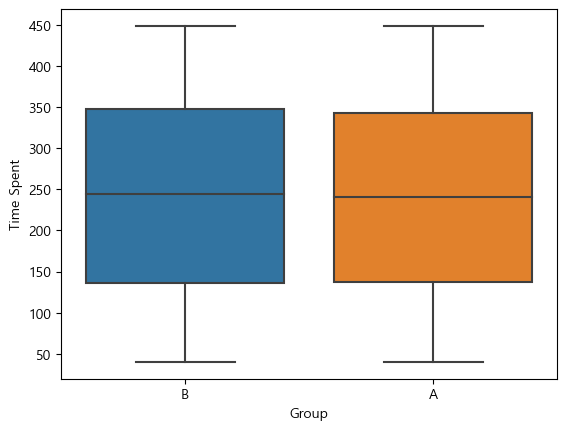

In [14]:
# 그래프
sns.boxplot(data=df, x=x, y=y)

<Axes: xlabel='Time Spent', ylabel='Density'>

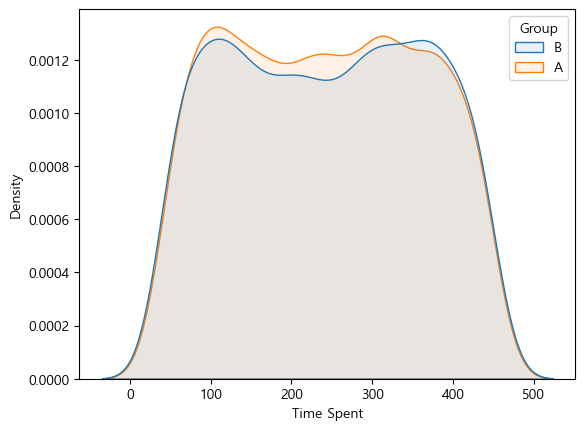

In [15]:
sns.kdeplot(data=df, x=y, hue=x, fill=True, alpha=0.1)

## Load unbalance data

In [2]:
raw = pd.read_csv('./data/AB test/Marketing AB Testing.csv', index_col=0)
raw.head(3)

user id test group  converted  total ads most ads day  most ads hour
0  1069124         ad      False        130       Monday             20
1  1119715         ad      False         93      Tuesday             22
2  1144181         ad      False         21      Tuesday             18

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


## EDA

In [4]:
raw.describe()

user id      total ads  most ads hour
count  5.881010e+05  588101.000000  588101.000000
mean   1.310692e+06      24.820876      14.469061
std    2.022260e+05      43.715181       4.834634
min    9.000000e+05       1.000000       0.000000
25%    1.143190e+06       4.000000      11.000000
50%    1.313725e+06      13.000000      14.000000
75%    1.484088e+06      27.000000      18.000000
max    1.654483e+06    2065.000000      23.000000

In [5]:
raw.groupby('test group').size()

test group
ad     564577
psa     23524
dtype: int64

In [6]:
raw.groupby('test group').describe().T.round(1) # 표본평균 및 분산 확인

test group                  ad       psa
user id       count   564577.0   23524.0
              mean   1327314.3  911761.5
              std     188918.1    6790.9
              min    1000000.0  900000.0
              25%    1163686.0  905880.8
              50%    1327362.0  911761.5
              75%    1490914.0  917642.2
              max    1654483.0  923523.0
total ads     count   564577.0   23524.0
              mean        24.8      24.8
              std         43.8      42.9
              min          1.0       1.0
              25%          4.0       4.0
              50%         13.0      12.0
              75%         27.0      26.0
              max       2065.0     907.0
most ads hour count   564577.0   23524.0
              mean        14.5      14.3
              std          4.8       4.7
              min          0.0       0.0
              25%         11.0      11.0
              50%         14.0      14.0
              75%         18.0      18.0
              max         23.0      23.0

In [7]:
pd.DataFrame(raw.groupby('test group')['converted'].value_counts(normalize=True)).sort_index() # 균형 확인

proportion
test group converted            
ad         False        0.974453
           True         0.025547
psa        False        0.982146
           True         0.017854

In [8]:
pd.DataFrame(raw.groupby('test group')['most ads day'].value_counts(normalize=True)).sort_index()

proportion
test group most ads day            
ad         Friday          0.157295
           Monday          0.148024
           Saturday        0.139577
           Sunday          0.145830
           Thursday        0.140064
           Tuesday         0.132085
           Wednesday       0.137126
psa        Friday          0.161665
           Monday          0.148869
           Saturday        0.121493
           Sunday          0.130037
           Thursday        0.166001
           Tuesday         0.123576
           Wednesday       0.148359

## Functions

In [9]:
def preprocess_data(df):
    """데이터 전처리 및 샘플링"""
    # Control 그룹과 Treatment 그룹의 크기 확인
    control_size = len(df[df['test_group'] == 'psa'])
    treatment_size = len(df[df['test_group'] == 'ad'])
    print(f"\n=== 원본 데이터 그룹 크기 ===")
    print(f"Control(psa) 그룹 크기: {control_size}")
    print(f"Treatment(ad) 그룹 크기: {treatment_size}")
    
    # Control 그룹은 전체 데이터 사용
    control_data = df[df['test_group'] == 'psa']
    # Treatment 그룹에서 Control 그룹 크기의 2배 정도로 샘플링
    sample_size = min(treatment_size, control_size * 2)
    treatment_data = df[df['test_group'] == 'ad'].sample(n=sample_size, random_state=42)
    
    print(f"\n=== 처리 후 데이터 그룹 크기 ===")
    print(f"Control(psa) 그룹 크기: {len(control_data)}")
    print(f"Treatment(ad) 그룹 크기: {len(treatment_data)}")
    
    # 데이터 병합
    processed_df = pd.concat([control_data, treatment_data])
    
    # 범주형 변수 더미화
    processed_df = pd.get_dummies(processed_df, columns=['most_ads_day'], drop_first=True)
    processed_df['test_group_binary'] = (processed_df['test_group'] == 'ad').astype(int)
    
    return processed_df

In [10]:
def visualize_distributions(df_before, df_after, var, treatment_col):
    """매칭 전후 연속형 변수 분포 시각화"""
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Before Matching', 'After Matching'))
    
    # Before Matching
    for i, group in enumerate([0, 1]):
        data = df_before[df_before[treatment_col] == group][var]
        fig.add_trace(
            go.Histogram(x=data, name=f'Group {group}', opacity=0.7),
            row=1, col=1
        )
    
    # After Matching
    for i, group in enumerate([0, 1]):
        data = df_after[df_after[treatment_col] == group][var]
        fig.add_trace(
            go.Histogram(x=data, name=f'Group {group}', opacity=0.7),
            row=1, col=2
        )
    
    fig.update_layout(
        title=f'Distribution of {var} Before and After Matching',
        barmode='overlay'
    )
    fig.show()

In [11]:
def calculate_smd(df, var, treatment_col):
    """표준화된 평균 차이(SMD) 계산"""
    treat = df[df[treatment_col] == 1][var]
    control = df[df[treatment_col] == 0][var]
    
    diff = treat.mean() - control.mean()
    pooled_std = np.sqrt((treat.var() + control.var()) / 2)
    
    return diff / pooled_std if pooled_std != 0 else 0

In [12]:
def evaluate_matching_quality(df_before, df_after, treatment_col, variables):
    """매칭 품질 평가 및 시각화 (개선된 버전)"""
    # 기존 SMD 계산 및 Love plot
    smd_before = {var: calculate_smd(df_before, var, treatment_col) for var in variables}
    smd_after = {var: calculate_smd(df_after, var, treatment_col) for var in variables}
    
    # Love plot (기존 코드 유지)
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=list(smd_before.values()),
        y=list(smd_before.keys()),
        name='Before Matching',
        mode='markers',
        marker=dict(size=10)
    ))
    
    fig.add_trace(go.Scatter(
        x=list(smd_after.values()),
        y=list(smd_after.keys()),
        name='After Matching',
        mode='markers',
        marker=dict(size=10)
    ))
    
    fig.add_vline(x=0, line_dash="dash", line_color="gray")
    fig.add_vline(x=0.1, line_dash="dash", line_color="red")
    fig.add_vline(x=-0.1, line_dash="dash", line_color="red")
    
    fig.update_layout(
        title='Standardized Mean Differences Before and After Matching',
        xaxis_title='Standardized Mean Difference',
        showlegend=True
    )
    
    fig.show()
    
    # 연속형 수에 대한 분포 비교
    continuous_vars = ['most_ads_hour']  # 필요한 연속형 변수 추가
    for var in continuous_vars:
        visualize_distributions(df_before, df_after, var, treatment_col)
    
    return smd_before, smd_after

In [13]:
def perform_psm(df):
    """개선된 프로펜시티 스코어 매칭 수행"""
    # 매칭 변수 설정 (더미화된 변수들 포함)
    matching_vars = ['most_ads_hour'] + [col for col in df.columns if col.startswith('most_ads_day_')]
    X = df[matching_vars]
    treatment = df['test_group_binary']
    
    # Propensity Score 계산
    ps_model = LogisticRegression(random_state=42)
    ps_model.fit(X, treatment)
    propensity_scores = ps_model.predict_proba(X)[:, 1]
    
    # 매칭 수행 (caliper 추가)
    caliper = 0.2 * np.std(propensity_scores)
    nn = NearestNeighbors(n_neighbors=1)
    
    treatment_idx = np.where(treatment == 1)[0]
    control_idx = np.where(treatment == 0)[0]
    
    # propensity score를 2D 배열로 변환
    control_ps = propensity_scores[control_idx].reshape(-1, 1)
    treatment_ps = propensity_scores[treatment_idx].reshape(-1, 1)
    
    nn.fit(control_ps)
    distances, matches = nn.kneighbors(treatment_ps)
    
    # caliper를 적용하여 매칭 필터링
    good_matches = distances.flatten() <= caliper
    
    matched_treatment_idx = treatment_idx[good_matches]
    matched_control_idx = control_idx[matches.flatten()[good_matches]]
    
    matched_df = pd.concat([
        df.iloc[matched_treatment_idx],
        df.iloc[matched_control_idx]
    ])
    
    # 매칭 품질 평가
    print("\n=== 매칭 품질 평가 ===")
    evaluate_matching_quality(
        df, matched_df, 
        'test_group_binary',
        matching_vars
    )
    
    return matched_df

In [14]:
def perform_logit_analysis(df):
    """개선된 로지스틱 회귀 분석 수행"""
    # 상호작용항 추가
    X = df[['test_group_binary', 'total_ads', 'most_ads_hour']]
    X['ads_treatment_interaction'] = X['total_ads'] * X['test_group_binary']
    X = sm.add_constant(X)
    y = df['converted']
    
    # VIF 계산
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\n=== VIF 분석 결과 ===")
    print(vif_data)
    
    # 로지스틱 회귀 분석
    model = sm.Logit(y, X)
    results = model.fit()
    
    # 변수 중요도 계산
    importance = pd.DataFrame({
        'variable': X.columns,
        'coefficient': results.params,
        'std_err': results.bse,
        'p_value': results.pvalues
    })
    importance['abs_importance'] = abs(importance['coefficient'])
    importance = importance.sort_values('abs_importance', ascending=False)
    
    print("\n=== 변수 중요도 ===")
    print(importance)
    
    print("\n=== Logit 분석 결과 ===")
    print(results.summary())
    
    return results, vif_data, importance

In [15]:
def calculate_insights(df, matched_df):
    """비즈니스 인사이트 계산 및 시각화 (개선된 버전)"""
    # 전환율 계산 (그룹명 수정)
    def calc_conversion_rate(data, group):
        group_data = data[data['test_group'] == group]
        return group_data['converted'].mean()
    
    # 전환율 계산
    original_control_cr = calc_conversion_rate(df, 'psa')
    original_treatment_cr = calc_conversion_rate(df, 'ad')
    matched_control_cr = calc_conversion_rate(matched_df, 'psa')
    matched_treatment_cr = calc_conversion_rate(matched_df, 'ad')
    
    # ATE 계산
    ate = matched_treatment_cr - matched_control_cr
    
    print("\n=== 전환율 분석 ===")
    print(f"Original Control CR: {original_control_cr:.4f}")
    print(f"Original Treatment CR: {original_treatment_cr:.4f}")
    print(f"Matched Control CR: {matched_control_cr:.4f}")
    print(f"Matched Treatment CR: {matched_treatment_cr:.4f}")
    print(f"Average Treatment Effect: {ate:.4f}")
    
    # 시각화
    plt.figure(figsize=(12, 6))
    
    # 전환율 비교 그래프
    plt.subplot(1, 2, 1)
    bars = plt.bar(['Control', 'Treatment'], 
                  [matched_control_cr, matched_treatment_cr],
                  color=['blue', 'orange'])
    plt.title('Conversion Rates After Matching')
    plt.ylabel('Conversion Rate')
    
    # 시간대별 전환율
    plt.subplot(1, 2, 2)
    hour_conversion = matched_df.groupby('most_ads_hour')['converted'].mean()
    hour_conversion.plot(kind='line', marker='o')
    plt.title('Conversion Rate by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Conversion Rate')
    
    plt.tight_layout()
    plt.show()
    
    return ate, {
        'original_control_cr': original_control_cr,
        'original_treatment_cr': original_treatment_cr,
        'matched_control_cr': matched_control_cr,
        'matched_treatment_cr': matched_treatment_cr,
        'ate': ate
    }

## Analysis

In [16]:
df = raw.copy()
df.columns = df.columns.str.strip().str.replace(' ', '_')

df.head(3)

user_id test_group  converted  total_ads most_ads_day  most_ads_hour
0  1069124         ad      False        130       Monday             20
1  1119715         ad      False         93      Tuesday             22
2  1144181         ad      False         21      Tuesday             18

In [17]:
processed_df = preprocess_data(df)


=== 원본 데이터 그룹 크기 ===
Control(psa) 그룹 크기: 23524
Treatment(ad) 그룹 크기: 564577

=== 처리 후 데이터 그룹 크기 ===
Control(psa) 그룹 크기: 23524
Treatment(ad) 그룹 크기: 47048


In [18]:
matched_df = perform_psm(processed_df)


=== 매칭 품질 평가 ===


In [19]:
logit_results, vif_data, importance = perform_logit_analysis(matched_df)


=== VIF 분석 결과 ===
                     feature        VIF
0                      const  11.903135
1          test_group_binary   1.600641
2                  total_ads   1.434920
3              most_ads_hour   1.011907
4  ads_treatment_interaction   1.392780
Optimization terminated successfully.
         Current function value: 0.106358
         Iterations 8

=== 변수 중요도 ===
                                            variable  coefficient   std_err  \
const                                          const    -4.081527  0.079973   
test_group_binary                  test_group_binary    -0.322031  0.056673   
most_ads_hour                          most_ads_hour     0.024916  0.004605   
ads_treatment_interaction  ads_treatment_interaction     0.012775  0.000525   
total_ads                                  total_ads    -0.001735  0.000389   

                                 p_value  abs_importance  
const                       0.000000e+00        4.081527  
test_group_binary           1.

C:\Users\rladk\AppData\Local\Temp\ipykernel_18968\269279275.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




=== 전환율 분석 ===
Original Control CR: 0.0179
Original Treatment CR: 0.0255
Matched Control CR: 0.0206
Matched Treatment CR: 0.0266
Average Treatment Effect: 0.0060


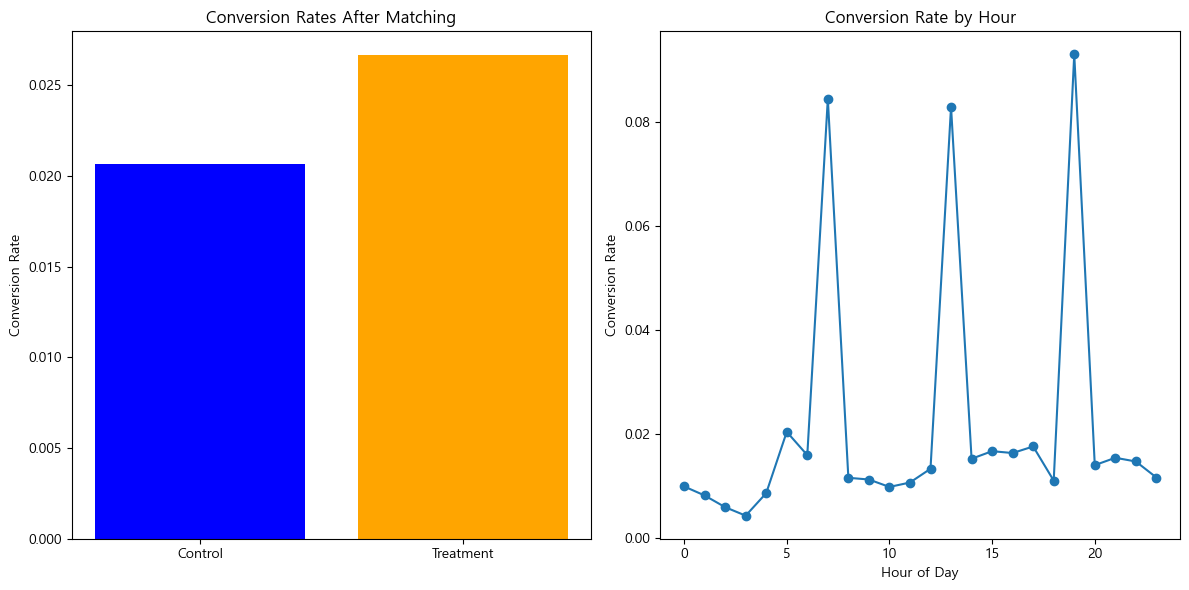

In [20]:
ate, conversion_metrics = calculate_insights(df, matched_df)

In [21]:
print("=== 마케팅 A/B 테스트 분석 보고서 ===\n\n")
print(f"데이터 크기: {len(df):,} rows\n")
print(f"매칭 후 데이터 크기: {len(matched_df):,} rows\n\n")

print("=== 전환율 분석 ===\n")
print(f"원본 Control 전환율: {conversion_metrics['original_control_cr']:.4f}\n")
print(f"원본 Treatment 전환율: {conversion_metrics['original_treatment_cr']:.4f}\n")
print(f"매칭 후 Control 전환율: {conversion_metrics['matched_control_cr']:.4f}\n")
print(f"매칭 후 Treatment 전환율: {conversion_metrics['matched_treatment_cr']:.4f}\n")
print(f"평균 처치 효과(ATE): {ate:.4f}\n\n")

print("=== 변수 중요도 ===\n")
print(importance.to_string())
print("\n\n=== VIF 분석 결과 ===\n")
print(vif_data.to_string())
print("\n\n=== Logit 분석 결과 ===\n")
print(logit_results.summary().as_text())

=== 마케팅 A/B 테스트 분석 보고서 ===


데이터 크기: 588,101 rows

매칭 후 데이터 크기: 94,096 rows


=== 전환율 분석 ===

원본 Control 전환율: 0.0179

원본 Treatment 전환율: 0.0255

매칭 후 Control 전환율: 0.0206

매칭 후 Treatment 전환율: 0.0266

평균 처치 효과(ATE): 0.0060


=== 변수 중요도 ===

                                            variable  coefficient   std_err        p_value  abs_importance
const                                          const    -4.081527  0.079973   0.000000e+00        4.081527
test_group_binary                  test_group_binary    -0.322031  0.056673   1.329048e-08        0.322031
most_ads_hour                          most_ads_hour     0.024916  0.004605   6.287911e-08        0.024916
ads_treatment_interaction  ads_treatment_interaction     0.012775  0.000525  1.345669e-130        0.012775
total_ads                                  total_ads    -0.001735  0.000389   8.293339e-06        0.001735


=== VIF 분석 결과 ===

                     feature        VIF
0                      const  11.903135
1          test_gro

# 기후동행카드

## Load data

### 대중교통 목적통행량

In [2]:
filepath = './data/대중교통 목적통행량/'
filelist = os.listdir(filepath)

raw = pd.DataFrame()
for f in filelist:
    tmp = pd.read_excel(filepath + f, header=1)
    tmp = tmp.drop(0, axis=0)
    tmp = tmp.drop(['시도코드'] + [i for i in tmp.columns if '도착량' in i], axis=1)
    tmp.columns = list(tmp.columns[:5]) + [str(int(i.split('.')[-1])+3) + '_발생량' for i in tmp.columns[5:]]

    for c in tmp.columns[:3]:
        tmp[c] = tmp[c].map(lambda x: None if x == 0 else x)
        tmp[c] = tmp[c].fillna(method='ffill')
    tmp['일'] = tmp['일'].map(lambda x: datetime.datetime.strptime(x.split('(')[0], '%Y-%m-%d'))

    raw = pd.concat([raw, tmp], axis=0)
    print(f, '--->', raw.shape)
    
raw.head(3)

이용량 지표(목적통행량)_220101_220114.xlsx ---> (4550, 29)
이용량 지표(목적통행량)_220115_220128.xlsx ---> (9082, 29)
이용량 지표(목적통행량)_220129_220211.xlsx ---> (13608, 29)
이용량 지표(목적통행량)_220212_220225.xlsx ---> (18158, 29)
이용량 지표(목적통행량)_220226_220311.xlsx ---> (22712, 29)
이용량 지표(목적통행량)_220312_220325.xlsx ---> (27260, 29)
이용량 지표(목적통행량)_220326_220408.xlsx ---> (31821, 29)
이용량 지표(목적통행량)_220409_220422.xlsx ---> (36390, 29)
이용량 지표(목적통행량)_220423_220506.xlsx ---> (40958, 29)
이용량 지표(목적통행량)_220507_220520.xlsx ---> (45525, 29)
이용량 지표(목적통행량)_220521_220603.xlsx ---> (50098, 29)
이용량 지표(목적통행량)_220604_220617.xlsx ---> (54673, 29)
이용량 지표(목적통행량)_220618_220701.xlsx ---> (59234, 29)
이용량 지표(목적통행량)_220702_220715.xlsx ---> (63803, 29)
이용량 지표(목적통행량)_220716_220729.xlsx ---> (68373, 29)
이용량 지표(목적통행량)_220730_220812.xlsx ---> (72953, 29)
이용량 지표(목적통행량)_220813_220826.xlsx ---> (77525, 29)
이용량 지표(목적통행량)_220827_220909.xlsx ---> (82096, 29)
이용량 지표(목적통행량)_220910_220923.xlsx ---> (86675, 29)
이용량 지표(목적통행량)_220924_221007.xlsx ---> (91253, 29)
이용

시도  시군구          일  이용자유형    발생량  4_발생량  5_발생량  6_발생량  7_발생량  8_발생량  \
1  서울특별시  강남구 2022-01-01     경로  16788      6    426   1109    509    632   
2  서울특별시  강남구 2022-01-01  국가유공자    356      1      8     19     13      7   
3  서울특별시  강남구 2022-01-01    어린이   1973      0      3      9      9     26   

   ...  18_발생량  19_발생량  20_발생량  21_발생량  22_발생량  23_발생량  24_발생량  25_발생량  \
1  ...    1055     621     613     571     219      35       0       0   
2  ...      23      14      13      13       2       1       2       0   
3  ...     147     111      78      59      34       1       0       0   

   26_발생량  27_발생량  
1       0       0  
2       0       0  
3       0       0  

[3 rows x 29 columns]

In [3]:
tab = pd.DataFrame(raw.groupby(['시도', '시군구', '일'])['발생량'].sum())
tab = tab.sort_index()
tab = tab.reset_index()

tab.head(3)

시도  시군구          일    발생량
0  광주광역시  광산구 2022-01-01  26473
1  광주광역시  광산구 2022-01-02  26698
2  광주광역시  광산구 2022-01-03  56775

In [4]:
for i in ['일반인', '어린이', '청소년', '경로', '장애인', '국가유공자', '외국인']:
    print(i, end=' ')
    tab = pd.merge(tab, 
                   raw.loc[raw['이용자유형'] == i, 
                           ['시도', '시군구', '일', '발생량']].rename(columns={'발생량':i}), 
                   on=['시도', '시군구', '일'], 
                   how='left')

일반인 어린이 청소년 경로 장애인 국가유공자 외국인 

In [5]:
for i in raw.columns[5:]:
    print(i, end=' ')
    tab = pd.merge(tab, 
                   raw.loc[:, ['시도', '시군구', '일', i]].groupby(['시도', '시군구', '일'])[i].sum(), 
                   on=['시도', '시군구', '일'], 
                   how='left')

4_발생량 5_발생량 6_발생량 7_발생량 8_발생량 9_발생량 10_발생량 11_발생량 12_발생량 13_발생량 14_발생량 15_발생량 16_발생량 17_발생량 18_발생량 19_발생량 20_발생량 21_발생량 22_발생량 23_발생량 24_발생량 25_발생량 26_발생량 27_발생량 

In [6]:
tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61349 entries, 0 to 61348
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   시도      61349 non-null  object        
 1   시군구     61349 non-null  object        
 2   일       61349 non-null  datetime64[ns]
 3   발생량     61349 non-null  int64         
 4   일반인     61332 non-null  float64       
 5   어린이     61240 non-null  float64       
 6   청소년     61212 non-null  float64       
 7   경로      54451 non-null  float64       
 8   장애인     54195 non-null  float64       
 9   국가유공자   54570 non-null  float64       
 10  외국인     30000 non-null  float64       
 11  4_발생량   61349 non-null  int64         
 12  5_발생량   61349 non-null  int64         
 13  6_발생량   61349 non-null  int64         
 14  7_발생량   61349 non-null  int64         
 15  8_발생량   61349 non-null  int64         
 16  9_발생량   61349 non-null  int64         
 17  10_발생량  61349 non-null  int64         
 18  11_발생량

In [7]:
tab.describe()

일           발생량            일반인  \
count                          61349  6.134900e+04   61332.000000   
mean   2023-06-03 14:41:08.930219008  1.767808e+05  143388.501141   
min              2022-01-01 00:00:00  1.000000e+00       1.000000   
25%              2022-09-17 00:00:00  6.991500e+04   54937.750000   
50%              2023-06-04 00:00:00  1.273770e+05   99132.000000   
75%              2024-02-18 00:00:00  2.460340e+05  202663.250000   
max              2024-10-31 00:00:00  1.018646e+06  863431.000000   
std                              NaN  1.492457e+05  125669.282813   

                어린이           청소년            경로           장애인         국가유공자  \
count  61240.000000  61212.000000  54451.000000  54195.000000  54570.000000   
mean    2545.945722   8099.479187  21385.042479   3693.222696    451.236888   
min        5.000000      0.000000      0.000000      0.000000      0.000000   
25%      934.000000   3644.000000   6751.500000    556.000000    214.250000   
50%     1705.000000   7079.000000  19127.000000   2674.000000    392.000000   
75%     2807.000000  10911.000000  31295.500000   5918.500000    632.000000   
max    23131.000000  48750.000000  97992.000000  16829.000000   2186.000000   
std     2813.835254   6106.288898  16937.660692   3570.865427    317.273306   

                외국인         4_발생량  ...         18_발생량        19_발생량  \
count  30000.000000  61349.000000  ...   61349.000000  61349.000000   
mean     336.968267    433.552967  ...   17074.892288   9740.842247   
min        0.000000      0.000000  ...       0.000000      0.000000   
25%       18.000000      1.000000  ...    5496.000000   3256.000000   
50%       65.000000    137.000000  ...   10358.000000   5873.000000   
75%      254.000000    693.000000  ...   18825.000000  12020.000000   
max     7897.000000   3036.000000  ...  164268.000000  93197.000000   
std      759.147117    585.583680  ...   22045.622352  11509.043372   

             20_발생량        21_발생량        22_발생량        23_발생량        24_발생량  \
count  61349.000000  61349.000000  61349.000000  61349.000000  61349.000000   
mean    8142.652073   7577.333551   5935.079154   2444.031492    472.815009   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     2764.000000   2619.000000   1868.000000    384.000000      1.000000   
50%     5043.000000   4450.000000   3299.000000   1251.000000    141.000000   
75%    10015.000000   9102.000000   7285.000000   3194.000000    651.000000   
max    64447.000000  95624.000000  67911.000000  29801.000000  27998.000000   
std     8909.825697   8702.624799   7219.173037   3224.213352    768.474235   

             25_발생량        26_발생량        27_발생량  
count  61349.000000  61349.000000  61349.000000  
mean      95.465158     54.844447     47.659489  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%       17.000000      0.000000      0.000000  
75%      138.000000     85.000000     80.000000  
max     9003.000000   2966.000000   1465.000000  
std      165.566937     93.378513     76.958617  

[8 rows x 33 columns]

In [8]:
tab.to_excel('./data/대중교통 목적통행량/rawdata_세부 목적통행량.xlsx', index=False)
tab.to_pickle('./data/대중교통 목적통행량/rawdata_세부 목적통행량.pickle')

### 대중교통 평균통행거리(km)

In [9]:
raw = pd.read_pickle('./data/대중교통 목적통행량/rawdata_세부 목적통행량.pickle')
raw = raw[['시도', '시군구', '일', '발생량']].copy()
raw['연월'] = raw['일'].map(lambda x: str(x)[:7].replace('-', ''))
raw['주차'] = raw['일'].map(lambda x: str(x.year) + str(x.strftime('%V')))
raw = raw.rename(columns={'발생량':'목적통행량'})

raw.head(3)

시도  시군구          일  목적통행량      연월      주차
0  광주광역시  광산구 2022-01-01  26473  202201  202252
1  광주광역시  광산구 2022-01-02  26698  202201  202252
2  광주광역시  광산구 2022-01-03  56775  202201  202201

In [10]:
filepath = './data/대중교통 평균통행거리/'
filelist = os.listdir(filepath)

raw_dist = pd.DataFrame()
for f in filelist:
    tmp = pd.read_excel(filepath + f)
    
    tmp = tmp.rename(columns={'월':'연월', '합계':'평균통행거리(km)'})
    tmp['연월'] = tmp['연월'].astype(str)
    
    for c in tmp.columns[:3]:
        tmp[c] = tmp[c].map(lambda x: None if x == 0 else x)
        tmp[c] = tmp[c].fillna(method='ffill')

    raw_dist = pd.concat([raw_dist, tmp], axis=0)
    print(f, '--->', raw_dist.shape)
    
raw_dist.head(3)

통행시간·거리 지표(평균통행거리)_202201.xlsx ---> (59, 5)
통행시간·거리 지표(평균통행거리)_202202.xlsx ---> (118, 5)
통행시간·거리 지표(평균통행거리)_202203.xlsx ---> (177, 5)
통행시간·거리 지표(평균통행거리)_202204.xlsx ---> (236, 5)
통행시간·거리 지표(평균통행거리)_202205.xlsx ---> (295, 5)
통행시간·거리 지표(평균통행거리)_202206.xlsx ---> (354, 5)
통행시간·거리 지표(평균통행거리)_202207.xlsx ---> (413, 5)
통행시간·거리 지표(평균통행거리)_202208.xlsx ---> (472, 5)
통행시간·거리 지표(평균통행거리)_202209.xlsx ---> (531, 5)
통행시간·거리 지표(평균통행거리)_202210.xlsx ---> (590, 5)
통행시간·거리 지표(평균통행거리)_202211.xlsx ---> (649, 5)
통행시간·거리 지표(평균통행거리)_202212.xlsx ---> (708, 5)
통행시간·거리 지표(평균통행거리)_202301.xlsx ---> (767, 5)
통행시간·거리 지표(평균통행거리)_202302.xlsx ---> (826, 5)
통행시간·거리 지표(평균통행거리)_202303.xlsx ---> (885, 5)
통행시간·거리 지표(평균통행거리)_202304.xlsx ---> (944, 5)
통행시간·거리 지표(평균통행거리)_202305.xlsx ---> (1003, 5)
통행시간·거리 지표(평균통행거리)_202306.xlsx ---> (1062, 5)
통행시간·거리 지표(평균통행거리)_202307.xlsx ---> (1122, 5)
통행시간·거리 지표(평균통행거리)_202308.xlsx ---> (1182, 5)
통행시간·거리 지표(평균통행거리)_202309.xlsx ---> (1242, 5)
통행시간·거리 지표(평균통행거리)_202310.xlsx ---> (1302, 5)
통행시간·

시도코드     시도  시군구      연월  평균통행거리(km)
0  11.0  서울특별시  강남구  202201       12.71
1  11.0  서울특별시  강동구  202201       10.29
2  11.0  서울특별시  강북구  202201        8.66

In [11]:
df = pd.merge(raw, raw_dist[['시도', '시군구', '연월', '평균통행거리(km)']], 
              on=['시도', '시군구', '연월'], how='left')
df = df.reset_index(drop=True)

df.sample(3)

시도  시군구          일   목적통행량      연월      주차  평균통행거리(km)
5275   대구광역시  군위군 2024-04-17       2  202404  202416        0.00
51714  서울특별시  성동구 2023-12-17  134065  202312  202350        9.93
7076   대구광역시  달서구 2023-08-06   76265  202308  202331        0.06

### 주민등록 인구

In [12]:
filepath = './data/주민등록인구/'
filelist = os.listdir(filepath)

raw_pop = pd.DataFrame()
for f in filelist:
    print(f)
    tmp = pd.read_csv(filepath + f, encoding='euc-kr')
    tmp = tmp.drop(0, axis=0)
    tmp2 = tmp[['행정구역'] + [i for i in tmp.columns if '총인구수' in i]].copy()

    for c in tmp2.columns[1:]:
        t = tmp2[['행정구역', c]].copy()
        t['시도'] = t['행정구역'].map(lambda x: x.split(' ')[0])
        t['시군구'] = t['행정구역'].map(lambda x: x.split(' ')[1])
        t['일'] = datetime.datetime.strptime(c.replace('_총인구수', ''), '%Y년%m월')
        t = t.rename(columns={c:'총 인구 수'})

        raw_pop = pd.concat([raw_pop, t[['시도', '시군구', '일', '총 인구 수']]], axis=0)
        print(c, '--->', raw_pop.shape)

raw_pop.head(3)

202201_202410_주민등록인구및세대현황_광주.csv
2022년01월_총인구수 ---> (5, 4)
2022년02월_총인구수 ---> (10, 4)
2022년03월_총인구수 ---> (15, 4)
2022년04월_총인구수 ---> (20, 4)
2022년05월_총인구수 ---> (25, 4)
2022년06월_총인구수 ---> (30, 4)
2022년07월_총인구수 ---> (35, 4)
2022년08월_총인구수 ---> (40, 4)
2022년09월_총인구수 ---> (45, 4)
2022년10월_총인구수 ---> (50, 4)
2022년11월_총인구수 ---> (55, 4)
2022년12월_총인구수 ---> (60, 4)
2023년01월_총인구수 ---> (65, 4)
2023년02월_총인구수 ---> (70, 4)
2023년03월_총인구수 ---> (75, 4)
2023년04월_총인구수 ---> (80, 4)
2023년05월_총인구수 ---> (85, 4)
2023년06월_총인구수 ---> (90, 4)
2023년07월_총인구수 ---> (95, 4)
2023년08월_총인구수 ---> (100, 4)
2023년09월_총인구수 ---> (105, 4)
2023년10월_총인구수 ---> (110, 4)
2023년11월_총인구수 ---> (115, 4)
2023년12월_총인구수 ---> (120, 4)
2024년01월_총인구수 ---> (125, 4)
2024년02월_총인구수 ---> (130, 4)
2024년03월_총인구수 ---> (135, 4)
2024년04월_총인구수 ---> (140, 4)
2024년05월_총인구수 ---> (145, 4)
2024년06월_총인구수 ---> (150, 4)
2024년07월_총인구수 ---> (155, 4)
2024년08월_총인구수 ---> (160, 4)
2024년09월_총인구수 ---> (165, 4)
2024년10월_총인구수 ---> (170, 4)
202201_202410_주민등록인구및세대현황_대구.csv
20

시도 시군구          일   총 인구 수
1  광주광역시  동구 2022-01-01  103,466
2  광주광역시  서구 2022-01-01  291,235
3  광주광역시  남구 2022-01-01  215,739

In [13]:
df = pd.merge(df, raw_pop, on=['시도', '시군구', '일'], how='left')
df['총 인구 수'] = df['총 인구 수'].fillna(method='ffill')
df['총 인구 수'] = df['총 인구 수'].map(lambda x: int(x.replace(',', '')))
df['인구당 목적통행량'] = round(df['목적통행량'] / (df['총 인구 수'] / 1000), 1) # 천명 단위

df.sample(3)

시도  시군구          일   목적통행량      연월      주차  평균통행거리(km)  총 인구 수  \
28172  부산광역시  사상구 2024-09-05  133240  202409  202436        4.70  199879   
12307  대구광역시  수성구 2023-10-01   63880  202310  202339        0.06  406802   
3714   광주광역시   북구 2023-09-02   61206  202309  202335        4.87  422776   

       인구당 목적통행량  
28172      666.6  
12307      157.0  
3714       144.8

### 방문객 수

In [14]:
filepath = './data/방문객 수/'
filelist = os.listdir(filepath)

raw_vis = pd.DataFrame()
for f in filelist:
    tmp = pd.read_csv(filepath + f, encoding='euc-kr')
    
    tmp2 = tmp.loc[tmp['방문자 구분'] == '전체방문자(a+b+c)'].copy()
    tmp2 = tmp2.rename(columns={'기준년월':'일', '광역지자체':'시도'})
    tmp2['일'] = tmp2['일'].map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    
    raw_vis = pd.concat([raw_vis, tmp2[['시도', '일', '방문자 수']]], axis=0)
    print(f, '--->', raw_vis.shape)

raw_vis.head(3)

방문자 수 추이_광주_2201.csv ---> (31, 3)
방문자 수 추이_광주_2202.csv ---> (59, 3)
방문자 수 추이_광주_2203.csv ---> (90, 3)
방문자 수 추이_광주_2204.csv ---> (120, 3)
방문자 수 추이_광주_2205.csv ---> (151, 3)
방문자 수 추이_광주_2206.csv ---> (181, 3)
방문자 수 추이_광주_2207.csv ---> (212, 3)
방문자 수 추이_광주_2208.csv ---> (243, 3)
방문자 수 추이_광주_2209.csv ---> (273, 3)
방문자 수 추이_광주_2210.csv ---> (304, 3)
방문자 수 추이_광주_2211.csv ---> (334, 3)
방문자 수 추이_광주_2212.csv ---> (365, 3)
방문자 수 추이_광주_2301.csv ---> (396, 3)
방문자 수 추이_광주_2302.csv ---> (424, 3)
방문자 수 추이_광주_2303.csv ---> (455, 3)
방문자 수 추이_광주_2304.csv ---> (485, 3)
방문자 수 추이_광주_2305.csv ---> (516, 3)
방문자 수 추이_광주_2306.csv ---> (546, 3)
방문자 수 추이_광주_2307.csv ---> (577, 3)
방문자 수 추이_광주_2308.csv ---> (608, 3)
방문자 수 추이_광주_2309.csv ---> (638, 3)
방문자 수 추이_광주_2310.csv ---> (669, 3)
방문자 수 추이_광주_2311.csv ---> (699, 3)
방문자 수 추이_광주_2312.csv ---> (730, 3)
방문자 수 추이_광주_2401.csv ---> (761, 3)
방문자 수 추이_광주_2402.csv ---> (790, 3)
방문자 수 추이_광주_2403.csv ---> (821, 3)
방문자 수 추이_광주_2404.csv ---> (851, 3)
방문자 수 추이_광주_2405.csv --

시도          일     방문자 수
124  광주광역시 2022-01-01  777793.0
125  광주광역시 2022-01-02  779073.0
126  광주광역시 2022-01-03  826813.0

In [15]:
df = pd.merge(df, raw_vis, on=['시도', '일'], how='left')

df.sample(3)

시도  시군구          일   목적통행량      연월      주차  평균통행거리(km)  총 인구 수  \
3519   광주광역시   북구 2023-02-19   39466  202302  202307        5.30  424013   
51048  서울특별시  성동구 2022-02-19  140041  202202  202207        9.93  285137   
38315  서울특별시  강북구 2024-02-11  113660  202402  202406        8.57  287040   

       인구당 목적통행량      방문자 수  
3519        93.1   890651.0  
51048      491.1  5667742.0  
38315      396.0  4989128.0

### 서울 택시 승차량 

In [16]:
raw_taxi = pd.read_csv('./data/서울 택시 승차량/서울시 택시 승차량_2022_2024.csv', encoding='utf-8')
raw_taxi['연월'] = raw_taxi['일'].map(lambda x: str(x)[:7].replace('-', ''))

raw_taxi.head(3)

시도  시군구           일  택시 승차량      연월
0  서울특별시  종로구  2022-01-01   20345  202201
1  서울특별시   중구  2022-01-01   24543  202201
2  서울특별시  용산구  2022-01-01   28056  202201

In [17]:
df = pd.merge(df, raw_taxi[['시도', '시군구', '연월', '택시 승차량']], 
              on=['시도', '시군구', '연월'], how='left')
df = df.reset_index(drop=True)

df.sample(3)

시도  시군구          일   목적통행량      연월      주차  평균통행거리(km)  총 인구 수  \
147    광주광역시  광산구 2022-05-28   49939  202205  202221        7.37  402793   
54675  서울특별시  양천구 2023-07-26  206601  202307  202330        8.88  438125   
31198  부산광역시  수영구 2024-06-18   92648  202406  202425        3.95  173167   

       인구당 목적통행량      방문자 수   택시 승차량  
147        124.0   859448.0      NaN  
54675      471.6  6300226.0  13159.0  
31198      535.0  1832831.0      NaN

### 서울 자동차 통행량

In [18]:
filepath = './data/서울 자동차 통행량/'
filelist = os.listdir(filepath)

raw_car = pd.DataFrame()
for f in filelist:
    tmp = pd.read_csv(filepath + f)
    tmp = tmp.rename(columns={'기준일':'일', '차량수량':'자동차 통행량'})
    tmp['일'] = tmp['일'].map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    
    tmp2 = pd.DataFrame(tmp.groupby(['일'])['자동차 통행량'].sum())
    tmp2['시도'] = '서울특별시'
    tmp2 = tmp2.reset_index()
    
    raw_car = pd.concat([raw_car, tmp2], axis=0)
    print(f, '--->', raw_car.shape)

raw_car.head(3)

TB_BDS_IDX_PASNG_202301.csv ---> (31, 3)
TB_BDS_IDX_PASNG_202302.csv ---> (59, 3)
TB_BDS_IDX_PASNG_202303.csv ---> (90, 3)
TB_BDS_IDX_PASNG_202304.csv ---> (120, 3)
TB_BDS_IDX_PASNG_202305.csv ---> (151, 3)
TB_BDS_IDX_PASNG_202306.csv ---> (181, 3)
TB_BDS_IDX_PASNG_202307.csv ---> (212, 3)
TB_BDS_IDX_PASNG_202308.csv ---> (243, 3)
TB_BDS_IDX_PASNG_202309.csv ---> (273, 3)
TB_BDS_IDX_PASNG_202310.csv ---> (304, 3)
TB_BDS_IDX_PASNG_202311.csv ---> (334, 3)
TB_BDS_IDX_PASNG_202312.csv ---> (365, 3)
TB_BDS_IDX_PASNG_202401.csv ---> (396, 3)
TB_BDS_IDX_PASNG_202402.csv ---> (411, 3)
TB_BDS_IDX_PASNG_202403.csv ---> (442, 3)
TB_BDS_IDX_PASNG_202404.csv ---> (472, 3)
TB_BDS_IDX_PASNG_202405.csv ---> (503, 3)
TB_BDS_IDX_PASNG_202406.csv ---> (533, 3)
TB_BDS_IDX_PASNG_202407.csv ---> (564, 3)


일  자동차 통행량     시도
0 2023-01-01   478022  서울특별시
1 2023-01-02   675992  서울특별시
2 2023-01-03   733454  서울특별시

In [19]:
df = pd.merge(df, raw_car, on=['시도', '일'], how='left')

df.sample(3)

시도  시군구          일   목적통행량      연월      주차  평균통행거리(km)  총 인구 수  \
39644  서울특별시  관악구 2022-01-31  125714  202201  202205        9.66  485610   
45563  서울특별시  도봉구 2024-02-14  162023  202402  202407        9.99  306542   
45300  서울특별시  도봉구 2023-05-27  120480  202305  202321       10.19  309622   

       인구당 목적통행량      방문자 수   택시 승차량   자동차 통행량  
39644      258.9  4758774.0  22327.0       NaN  
45563      528.6  5911357.0   8968.0  746815.0  
45300      389.1  6265173.0   9476.0  593465.0

### 서울 따릉이 이용량

In [20]:
filepath = './data/서울 따릉이 이용량/'
filelist = os.listdir(filepath)

raw_bic = pd.DataFrame()
for f in filelist:
    tmp = pd.read_csv(filepath + f)
    tmp2 = tmp.loc[tmp['제목'] == '따릉이'].copy()
    tmp2 = tmp2.rename(columns={'기준일':'일', '서울_수':'따릉이 이용량'})
    tmp2['일'] = tmp2['일'].map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    tmp2['시도'] = '서울특별시'
    
    raw_bic = pd.concat([raw_bic, tmp2[['시도', '일', '따릉이 이용량']]], axis=0)
    print(f, '--->', raw_bic.shape)

raw_bic.head(3)

TB_BDS_PBTRNSP_USE_INFO_202301.csv ---> (31, 3)
TB_BDS_PBTRNSP_USE_INFO_202302.csv ---> (59, 3)
TB_BDS_PBTRNSP_USE_INFO_202303.csv ---> (90, 3)
TB_BDS_PBTRNSP_USE_INFO_202304.csv ---> (120, 3)
TB_BDS_PBTRNSP_USE_INFO_202305.csv ---> (151, 3)
TB_BDS_PBTRNSP_USE_INFO_202306.csv ---> (181, 3)
TB_BDS_PBTRNSP_USE_INFO_202307.csv ---> (212, 3)
TB_BDS_PBTRNSP_USE_INFO_202308.csv ---> (243, 3)
TB_BDS_PBTRNSP_USE_INFO_202309.csv ---> (273, 3)
TB_BDS_PBTRNSP_USE_INFO_202310.csv ---> (304, 3)
TB_BDS_PBTRNSP_USE_INFO_202311.csv ---> (334, 3)
TB_BDS_PBTRNSP_USE_INFO_202312.csv ---> (365, 3)
TB_BDS_PBTRNSP_USE_INFO_202401.csv ---> (396, 3)
TB_BDS_PBTRNSP_USE_INFO_202402.csv ---> (411, 3)
TB_BDS_PBTRNSP_USE_INFO_202403.csv ---> (442, 3)
TB_BDS_PBTRNSP_USE_INFO_202404.csv ---> (472, 3)
TB_BDS_PBTRNSP_USE_INFO_202405.csv ---> (503, 3)
TB_BDS_PBTRNSP_USE_INFO_202406.csv ---> (533, 3)
TB_BDS_PBTRNSP_USE_INFO_202407.csv ---> (564, 3)


시도          일  따릉이 이용량
0   서울특별시 2023-01-01   792143
5   서울특별시 2023-01-02   842812
10  서울특별시 2023-01-03   612788

In [21]:
df = pd.merge(df, raw_bic, on=['시도', '일'], how='left')

df.sample(3)

시도  시군구          일   목적통행량      연월      주차  평균통행거리(km)  총 인구 수  \
37008  서울특별시  강동구 2023-05-15  220774  202305  202320       10.35  459275   
5801   대구광역시   남구 2022-12-09   55823  202212  202249        0.05  141519   
36457  서울특별시  강남구 2024-09-10  976011  202409  202437       12.22  558508   

       인구당 목적통행량      방문자 수   택시 승차량   자동차 통행량   따릉이 이용량  
37008      480.7  6692381.0  17778.0  758064.0  842812.0  
5801       394.5  1543362.0      NaN       NaN       NaN  
36457     1747.5  6204979.0  84086.0       NaN       NaN

## Pre-processing

In [22]:
treat_date = datetime.datetime(2024,1,27,0,0)
end_date = datetime.datetime(2024,10,31,0,0)

df = df.loc[df['일'] < end_date].copy()
df['treated'] = df['시도'].map(lambda x: 1 if x == '서울특별시' else 0)
df['post'] = df['일'].map(lambda x: 1 if x >= treat_date else 0)
df['w'] = df['treated'] * df['post']

df['일자'] = df['일'].map(lambda x: x.date())
df = df.reindex(columns=[
    '연월', '일자', '주차', '시도', '시군구',  
    '목적통행량', '평균통행거리(km)', '총 인구 수', '인구당 목적통행량',  
    '택시 승차량', '자동차 통행량', '따릉이 이용량', '방문자 수',
   'treated', 'post', 'w'])

df.head(3)

연월          일자      주차     시도  시군구  목적통행량  평균통행거리(km)  총 인구 수  \
0  202201  2022-01-01  202252  광주광역시  광산구  26473         7.1  404319   
1  202201  2022-01-02  202252  광주광역시  광산구  26698         7.1  404319   
2  202201  2022-01-03  202201  광주광역시  광산구  56775         7.1  404319   

   인구당 목적통행량  택시 승차량  자동차 통행량  따릉이 이용량     방문자 수  treated  post  w  
0       65.5     NaN      NaN      NaN  777793.0        0     0  0  
1       66.0     NaN      NaN      NaN  779073.0        0     0  0  
2      140.4     NaN      NaN      NaN  826813.0        0     0  0

In [23]:
df.to_excel('./data/rawdata.xlsx', index=False)
df.to_pickle('./data/rawdata.pickle')

## EDA (Reload data)

In [3]:
raw = pd.read_pickle('./data/rawdata.pickle')

raw.head(3)

연월          일자      주차     시도  시군구  목적통행량  평균통행거리(km)  총 인구 수  \
0  202201  2022-01-01  202252  광주광역시  광산구  26473         7.1  404319   
1  202201  2022-01-02  202252  광주광역시  광산구  26698         7.1  404319   
2  202201  2022-01-03  202201  광주광역시  광산구  56775         7.1  404319   

   인구당 목적통행량  택시 승차량  자동차 통행량  따릉이 이용량     방문자 수  treated  post  w  
0       65.5     NaN      NaN      NaN  777793.0        0     0  0  
1       66.0     NaN      NaN      NaN  779073.0        0     0  0  
2      140.4     NaN      NaN      NaN  826813.0        0     0  0

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61289 entries, 0 to 61347
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   연월          61289 non-null  object 
 1   일자          61289 non-null  object 
 2   주차          61289 non-null  object 
 3   시도          61289 non-null  object 
 4   시군구         61289 non-null  object 
 5   목적통행량       61289 non-null  int64  
 6   평균통행거리(km)  59489 non-null  float64
 7   총 인구 수      61289 non-null  int64  
 8   인구당 목적통행량   61289 non-null  float64
 9   택시 승차량      25850 non-null  float64
 10  자동차 통행량     14100 non-null  float64
 11  따릉이 이용량     14100 non-null  float64
 12  방문자 수       61289 non-null  float64
 13  treated     61289 non-null  int64  
 14  post        61289 non-null  int64  
 15  w           61289 non-null  int64  
dtypes: float64(6), int64(5), object(5)
memory usage: 7.9+ MB


In [4]:
tmp = pd.DataFrame(raw.groupby('시도')['시군구'].unique())
tmp['len'] = tmp['시군구'].map(len)
tmp

시군구  len
시도                                                           
광주광역시                              [광산구, 남구, 동구, 북구, 서구]    5
대구광역시           [군위군, 남구, 달서구, 달성군, 동구, 북구, 서구, 수성구, 중구]    9
대전광역시                             [대덕구, 동구, 서구, 유성구, 중구]    5
부산광역시  [강서구, 금정구, 기장군, 남구, 동구, 동래구, 부산진구, 북구, 사상구, 사하...   16
서울특별시  [강남구, 강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, ...   25

In [5]:
raw.groupby('시도')[raw.columns[5:-3]].mean().round() # 그룹별 통계량

목적통행량  평균통행거리(km)    총 인구 수  인구당 목적통행량   택시 승차량   자동차 통행량   따릉이 이용량  \
시도                                                                              
광주광역시   52706.0         6.0  285075.0      217.0      NaN       NaN       NaN   
대구광역시   83263.0         0.0  287511.0      368.0      NaN       NaN       NaN   
대전광역시   71048.0         8.0  288976.0      250.0      NaN       NaN       NaN   
부산광역시  105371.0         5.0  206777.0      606.0      NaN       NaN       NaN   
서울특별시  299309.0        11.0  376912.0      936.0  24382.0  694184.0  733658.0   

           방문자 수  
시도                
광주광역시   875887.0  
대구광역시  1455442.0  
대전광역시   944369.0  
부산광역시  1892170.0  
서울특별시  6139549.0

In [6]:
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=df, x='일자', y='인구당 목적통행량', hue='시도')
# for y in range(2022, 2025):
#     plt.axvline(datetime.datetime(y,1,1,0,0), color='gray', linestyle='--')
# plt.legend(bbox_to_anchor=(1,1))

In [7]:
#sv.analyze(df).show_html('./EDA.html')

In [8]:
# sv.compare(df.loc[df['region'] == '서울특별시'], 
#            df.loc[df['region'] != '서울특별시']).show_html('./data/compared_EDA.html')

## T-test

In [5]:
df = raw.loc[(raw['시도'] == '서울특별시') & 
             (raw['일자'].map(lambda x: x.year) >= 2023) &
             (raw['일자'].map(lambda x: x.month) >= 2) &
             (raw['일자'].map(lambda x: x.month) <= 10),
             ['시도', '시군구', '일자', '목적통행량']].copy()
df['group'] = df['일자'].map(lambda x: 'before' if x.year == 2023 else 'after')

df.head(3)

시도  시군구          일자   목적통행량   group
35870  서울특별시  강남구  2023-02-01  933965  before
35871  서울특별시  강남구  2023-02-02  945194  before
35872  서울특별시  강남구  2023-02-03  973296  before

In [6]:
res = pd.DataFrame(df.loc[df['group'] == 'before'].groupby('시군구')['목적통행량'].mean())
res.columns = ['before']
res['after'] = df.loc[df['group'] == 'after'].groupby('시군구')['목적통행량'].mean()
res = res.round()
res.loc['mean'] = res.mean()
res.loc['total'] = res.sum(axis=0)
res

before       after
시군구                          
강남구     787517.00   796536.00
강동구     190620.00   196182.00
강북구     192590.00   194024.00
강서구     334265.00   339418.00
관악구     325408.00   328779.00
광진구     247357.00   250626.00
구로구     297227.00   299983.00
금천구     176360.00   174750.00
노원구     263784.00   271412.00
도봉구     150995.00   154151.00
동대문구    258537.00   268108.00
동작구     270668.00   275684.00
마포구     405241.00   418921.00
서대문구    224086.00   227832.00
서초구     438899.00   442917.00
성동구     226983.00   235687.00
성북구     263463.00   268338.00
송파구     461806.00   474656.00
양천구     184269.00   186256.00
영등포구    418181.00   427009.00
용산구     256698.00   264583.00
은평구     246609.00   251785.00
종로구     411853.00   417375.00
중구      468866.00   489667.00
중랑구     185842.00   189250.00
mean    307524.96   313757.16
total  7995648.96  8157686.16

In [11]:
t_stat, p_value = stats.ttest_rel(res['before'], res['after'])

print(f"T-statistic: {t_stat.round(4)}")
print(f"P-value: {p_value.round(4)}")
print('----------')

if p_value < 0.05:
    print("기후동행카드 도입에 따른 목적통행량에 유의미한 차이가 있습니다.")
    if t_stat > 0:
        print("도입 이전(2023년) 대비 도입 이후(2024년) 목적통행량이 감소하였습니다.")
    else:
        print("도입 이전(2023년) 대비 도입 이후(2024년) 목적통행량이 증가하였습니다.")
else:
    print("기후동행카드 도입에 따른 목적통행량에 유의미한 차이가 없습니다.")
    
print('----------')
print('서울시 월평균 목적통행량 변화:')
print(res.sum())
print('전년 동기 목적통행량 증가량 :', res.sum()['after'] - res.sum()['before'])

T-statistic: -2.0589
P-value: 0.0501
----------
기후동행카드 도입에 따른 목적통행량에 유의미한 차이가 없습니다.
----------
서울시 월평균 목적통행량 변화:
before    15376248.0
after     15687858.0
dtype: float64
전년 동기 목적통행량 증가량 : 311610.0


## DID

In [2]:
raw = pd.read_pickle('./data/rawdata.pickle')

start_date = datetime.date(2022, 11, 1)

df = raw.loc[(raw['시도'].map(lambda x: x in ['서울특별시', '부산광역시'])) &
    (raw['일자'] >= start_date),
    ['일자', '시도', '시군구', '목적통행량', 'treated', 'post', 'w']].copy()
df['일자'] = df['일자'].map(lambda x: datetime.datetime.combine(x, datetime.datetime.min.time()))
df = df.reset_index(drop=True)

df.head(3)

일자     시도  시군구  목적통행량  treated  post  w
0 2022-11-01  부산광역시  강서구  45163        0     0  0
1 2022-11-02  부산광역시  강서구  45933        0     0  0
2 2022-11-03  부산광역시  강서구  46304        0     0  0

In [3]:
x = '일자'
y = '목적통행량'

df_did = (df.groupby(["treated", "post"]).agg({y:"mean", x: ["min", "max"]}))
df_did['목적통행량'] = df_did['목적통행량'].round(1)

df_did

목적통행량         일자           
                  mean        min        max
treated post                                
0       0     107753.9 2022-11-01 2024-01-26
        1     107157.4 2024-01-27 2024-10-30
1       0     305141.6 2022-11-01 2024-01-26
        1     313286.3 2024-01-27 2024-10-30

In [4]:
y0_est = (df_did.loc[1].loc[0, y] # treated baseline(treat 1 / post 0)
          + df_did.loc[0].diff().loc[1,y]) # control 추세

att = df_did.loc[1].loc[1, y] - y0_est
att

mean    8741.2
dtype: object

In [5]:
# 고정효과 회귀
df = df.rename(columns={'목적통행량':'y'})

m = smf.ols('y ~ treated:post + C(시도) + C(시군구) + C(일자)', data=df).fit()

m.params['treated:post'] # 인과 효과 추정량(시군구, 일 단위)

8741.188502573583

In [6]:
m.conf_int().loc['treated:post'] # 신뢰구간

0     6754.444288
1    10727.932717
Name: treated:post, dtype: float64

## Parallel trend

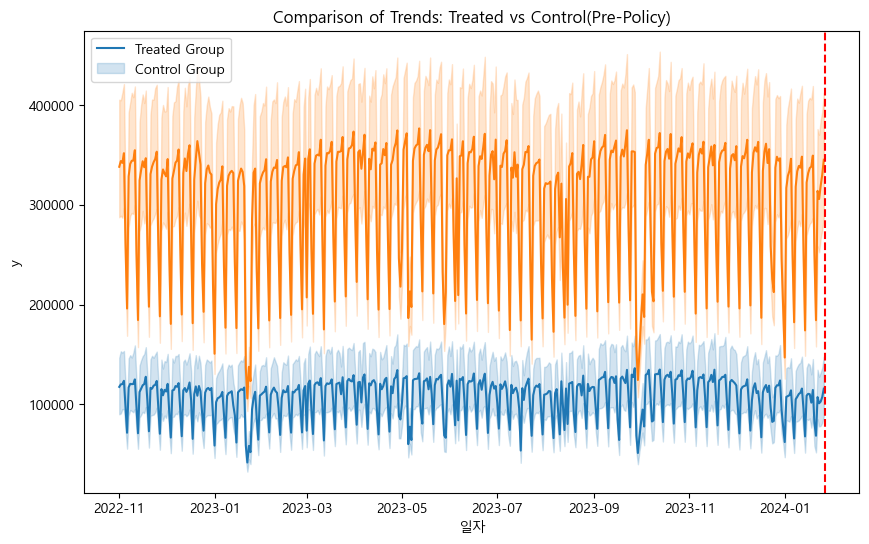

In [17]:
#1) 시각적 검증 (Pre-treatment기간)

pre_data = df[df['post'] == 0]
policy_start_date = pd.to_datetime('2024-01-27') 

plt.figure(figsize=(10, 6))
sns.lineplot(data=pre_data, x='일자', y='y', hue='treated', estimator='mean')
plt.axvline(x=policy_start_date, color='red', linestyle='--', label='Policy Start')
plt.title('Comparison of Trends: Treated vs Control(Pre-Policy)')
plt.legend(['Treated Group', 'Control Group'])
plt.show()

=> 결과: 두 집단이 시간에 따라 동일한 기울기로 증가 또는 감소, 평행추세가정 만족

C:\Users\rladk\AppData\Local\Temp\ipykernel_12792\3933314236.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='일자', y='y', hue='treated', estimator='mean', ci=None)  # 처리 여부에 따른 추세 그래프


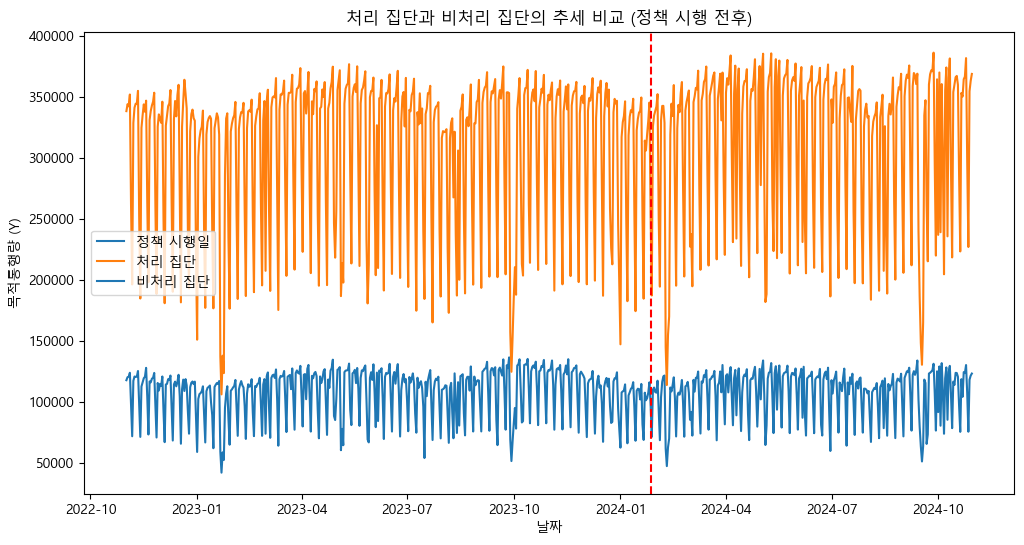

In [18]:
#1) 시각적 검증 (전체 기간)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='일자', y='y', hue='treated', estimator='mean', ci=None)  # 처리 여부에 따른 추세 그래프
plt.axvline(x=policy_start_date, color='red', linestyle='--', label='정책 시행일')  # 정책 시행일 기준선
plt.title('처리 집단과 비처리 집단의 추세 비교 (정책 시행 전후)')
plt.xlabel('날짜')
plt.ylabel('목적통행량 (Y)')
plt.legend(['정책 시행일', '처리 집단', '비처리 집단'])  # 범례 추가
plt.show()

In [24]:
#2) Placebo 테스트
res_placebo = pd.DataFrame(columns=['coef', 'p_value'])

for m in range(2, 12):
    placebo_date = pd.to_datetime(datetime.date(2023, m, 1))
    pre_data['placebo_post'] = pre_data['일자'] >= placebo_date

    model = smf.ols('y ~ treated * placebo_post + C(시군구)', data=pre_data).fit()
    res_placebo.loc[m] = [model.params['treated:placebo_post[T.True]'], 
          model.pvalues['treated:placebo_post[T.True]'].round(4)]

C:\Users\rladk\AppData\Local\Temp\ipykernel_16216\1491600222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_data['placebo_post'] = pre_data['일자'] >= placebo_date
C:\Users\rladk\AppData\Local\Temp\ipykernel_16216\1491600222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_data['placebo_post'] = pre_data['일자'] >= placebo_date
C:\Users\rladk\AppData\Local\Temp\ipykernel_16216\1491600222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [27]:
res_placebo.loc['mean'] = res_placebo.mean()
res_placebo['significant'] = res_placebo['p_value'] < 0.05

res_placebo

coef  p_value  significant
2     7012.145059  0.00210         True
3     5236.533784  0.01190         True
4     1848.925778  0.34340        False
5      -25.037050  0.98940        False
6    -1217.812311  0.50940        False
7    -2751.495599  0.13630        False
8    -2499.157349  0.18450        False
9     -475.627057  0.80850        False
10     655.634466  0.75450        False
11    3862.636094  0.09820        False
mean  1164.674582  0.38382        False

In [19]:
# 정책 시행 이전 데이터를 기반으로 Placebo 분석(임의의 날짜 설정)
placebo_date = pd.to_datetime('2023-11-01')  # 임의의 가상 정책 도입일
pre_data['placebo_post'] = pre_data['일자'] >= placebo_date

# 3. Placebo Test를 위한 DID 회귀모델 생성
model = smf.ols('y ~ treated * placebo_post + C(시군구)', data=pre_data).fit()

# 4. 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     2597.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:44:47   Log-Likelihood:            -2.3052e+05
No. Observations:               18532   AIC:                         4.611e+05
Df Residuals:                   18490   BIC:                         4.615e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

C:\Users\rladk\AppData\Local\Temp\ipykernel_12792\2965563208.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_data['placebo_post'] = pre_data['일자'] >= placebo_date


=> 결과: p-value=0.098 (유의수준 10%에서는 유의, 5%에서는 유의하지 않음)
처리 집단과 비처리 집단 간의 변화가 통계적으로 유의하지 않다고 볼 수 있음.
해석: Placebo 정책 시행 이후 두 집단 간의 추세 변화는 유의미하지 않으므로, 평행추세 가정이 대체로 성립한다고 볼 수 있습니다.

## RD

In [9]:
raw = pd.read_pickle('./data/rawdata.pickle')

raw.head(3)

연월          일자      주차     시도  시군구  목적통행량  평균통행거리(km)  총 인구 수  \
0  202201  2022-01-01  202252  광주광역시  광산구  26473         7.1  404319   
1  202201  2022-01-02  202252  광주광역시  광산구  26698         7.1  404319   
2  202201  2022-01-03  202201  광주광역시  광산구  56775         7.1  404319   

   인구당 목적통행량  택시 승차량  자동차 통행량  따릉이 이용량     방문자 수  treated  post  w  
0       65.5     NaN      NaN      NaN  777793.0        0     0  0  
1       66.0     NaN      NaN      NaN  779073.0        0     0  0  
2      140.4     NaN      NaN      NaN  826813.0        0     0  0

In [14]:
start_date = datetime.date(2024, 1, 15) # 12days
end_date = datetime.date(2024, 2, 7)
cutoff_date = pd.Timestamp('2024-01-27')

df = raw.loc[(raw['시도'] == '서울특별시') &
             (raw['일자'] >= start_date) & 
             (raw['일자'] <= end_date),
    ['일자', '시도', '시군구', '목적통행량']].copy()
df = pd.DataFrame(df.groupby('일자')['목적통행량'].mean())
df = df.reset_index()
df['일자'] = pd.to_datetime(df['일자'])
df['treat'] = (df['일자'] >= cutoff_date).astype(int)
df['days'] = (df['일자'] - cutoff_date).dt.days

df.head(3)

일자      목적통행량  treat  days
0 2024-01-15  322315.56      0   -12
1 2024-01-16  331628.80      0   -11
2 2024-01-17  336718.96      0   -10

<Figure size 1000x600 with 0 Axes>

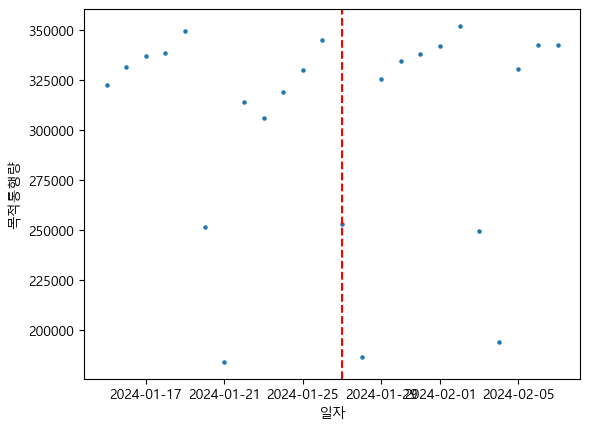

In [15]:
plt.figure(figsize=(10, 6))
df.plot.scatter(x='일자', y='목적통행량', s=5)
policy_start_date = pd.to_datetime('2024-01-27') 
plt.axvline(x=policy_start_date, color='red', linestyle='--')

In [16]:
model = smf.wls('목적통행량 ~ days * treat', df).fit()

print(model.summary())

                            WLS Regression Results                            
Dep. Variable:                  목적통행량   R-squared:                       0.069
Model:                            WLS   Adj. R-squared:                 -0.070
Method:                 Least Squares   F-statistic:                    0.4957
Date:                Sun, 08 Dec 2024   Prob (F-statistic):              0.689
Time:                        00:01:29   Log-Likelihood:                -294.08
No. Observations:                  24   AIC:                             596.2
Df Residuals:                      20   BIC:                             600.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.056e+05   3.42e+04      8.932      0.0

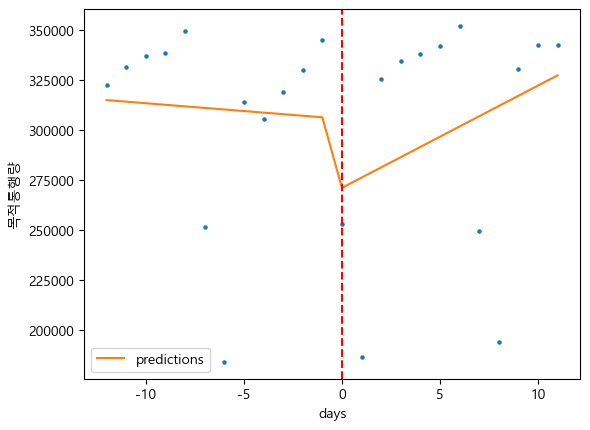

In [17]:
ax = df.plot.scatter(x='days', y='목적통행량', color='C0', s=5)
df.assign(predictions=model.fittedvalues).plot(x='days', y="predictions", ax=ax, color='C1')
plt.axvline(x=0, color='red', linestyle='--')

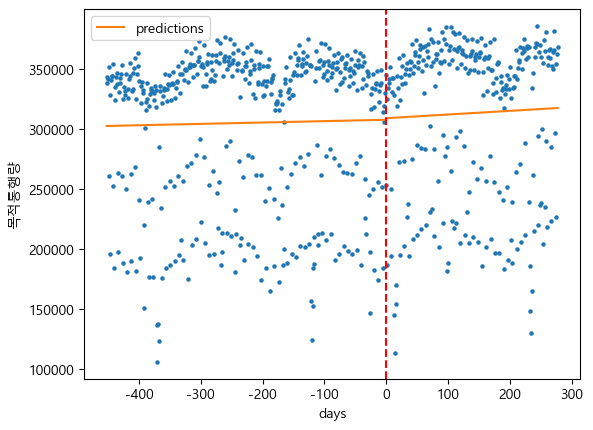

In [11]:
ax = df.plot.scatter(x='days', y='목적통행량', color='C0', s=5)
df.assign(predictions=model.fittedvalues).plot(x='days', y="predictions", ax=ax, color='C1')
plt.axvline(x=0, color='red', linestyle='--')